In [1]:
# Import libraries
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
import json
import joblib as joblib
import pickle as pickle

In [2]:
# nltk.download('punkt')
# pip install unidecode


In [3]:
# Load data
data_train = pd.read_csv('../../Data Splits/train_data_70_30.csv')


In [4]:
X_train = data_train['article']
y_train = data_train['label']

In [5]:
# Initialize Porter Stemmer
ps = PorterStemmer()

# Load stopwords
with open('../../Datasets/stopwords-tl.json', 'r') as f:
    stopwords = json.load(f)

# Custom transformer for text preprocessing
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return [' '.join(self.preprocess(text)) for text in X]
    
    def preprocess(self, text):
        tokens = nltk.word_tokenize(text)
        stems = [ps.stem(token) for token in tokens]
        filtered = [stem for stem in stems if stem not in stopwords]
        return filtered

In [6]:
# Initializing base models

mnb = MultinomialNB()
lr = LogisticRegression()
rf = RandomForestClassifier()
knn = KNeighborsClassifier()
svm = SVC(probability=True)

base_models = [mnb, lr, rf, knn, svm]
base_names = ['MNB', 'LR', 'RF', 'KNN', 'SVM']

# Define the parameter grid
param_grid = {
    
    'n_neighbors': [3, 5, 7, 9, 11],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weighting scheme
    'metric': ['euclidean', 'cosine', 'manhattan', 'minkowski']  # Distance metric
}

Metrics for MNB:
Accuracy: 0.9381606765327696
Precision: 0.8947867298578199
Recall: 0.9936842105263158
F1 Score: 0.9416458852867831
AUC: 0.9956173874175885
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       942
           1       0.89      0.99      0.94       950

    accuracy                           0.94      1892
   macro avg       0.94      0.94      0.94      1892
weighted avg       0.94      0.94      0.94      1892



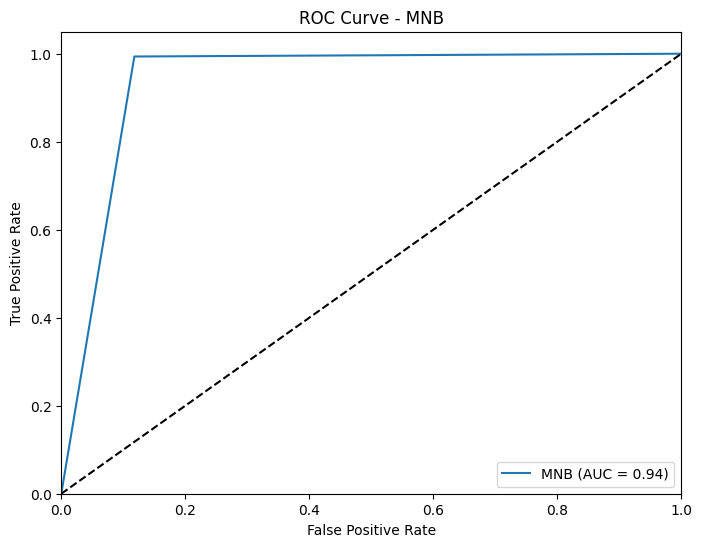

Metrics for LR:
Accuracy: 0.9439746300211417
Precision: 0.9929906542056075
Recall: 0.8947368421052632
F1 Score: 0.9413067552602437
AUC: 0.9966554922337691
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.95       942
           1       0.99      0.89      0.94       950

    accuracy                           0.94      1892
   macro avg       0.95      0.94      0.94      1892
weighted avg       0.95      0.94      0.94      1892



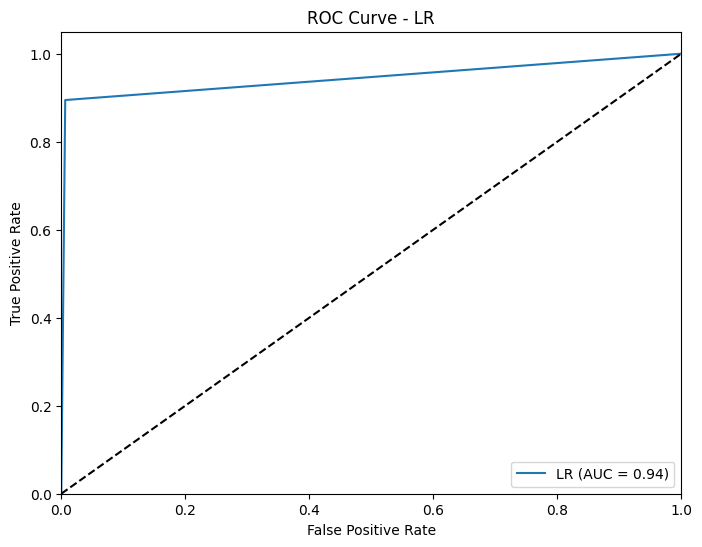

Metrics for RF:
Accuracy: 0.9894291754756871
Precision: 1.0
Recall: 0.9789473684210527
F1 Score: 0.9893617021276596
AUC: 0.9999044585987261
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       942
           1       1.00      0.98      0.99       950

    accuracy                           0.99      1892
   macro avg       0.99      0.99      0.99      1892
weighted avg       0.99      0.99      0.99      1892



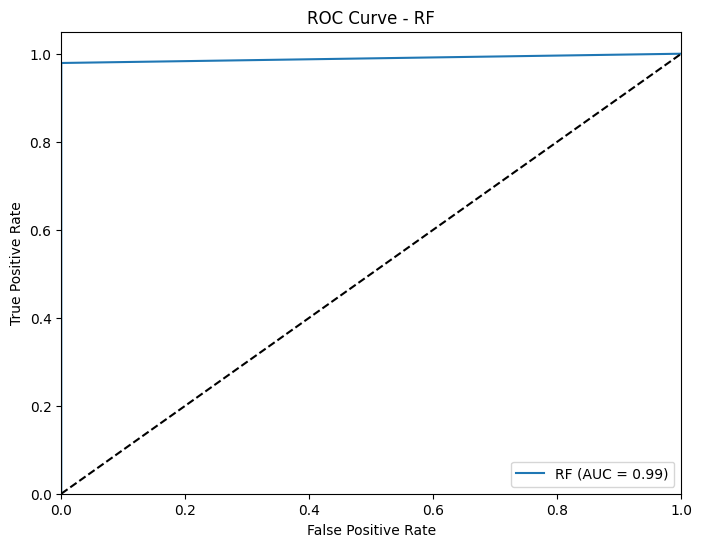

Metrics for KNN:
Accuracy: 0.9016913319238901
Precision: 0.8590225563909775
Recall: 0.9621052631578947
F1 Score: 0.9076464746772592
AUC: 0.977610906246508
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.84      0.89       942
           1       0.86      0.96      0.91       950

    accuracy                           0.90      1892
   macro avg       0.91      0.90      0.90      1892
weighted avg       0.91      0.90      0.90      1892



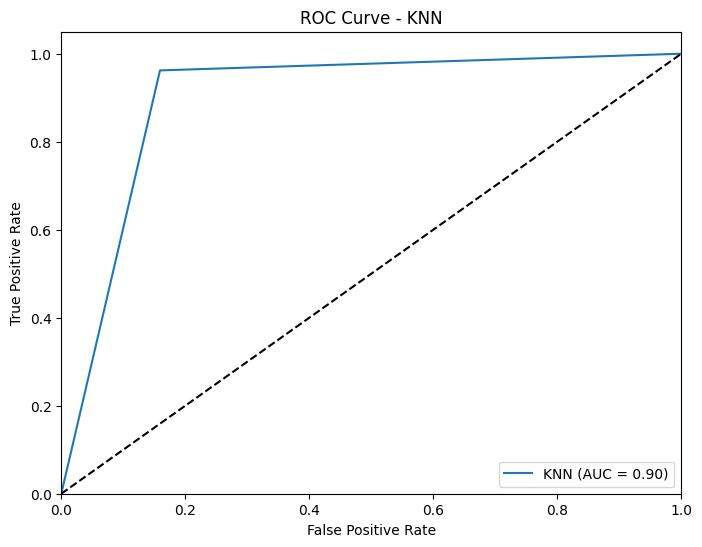

Metrics for SVM:
Accuracy: 0.9920718816067653
Precision: 1.0
Recall: 0.9842105263157894
F1 Score: 0.9920424403183024
AUC: 0.999986590680523
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       942
           1       1.00      0.98      0.99       950

    accuracy                           0.99      1892
   macro avg       0.99      0.99      0.99      1892
weighted avg       0.99      0.99      0.99      1892



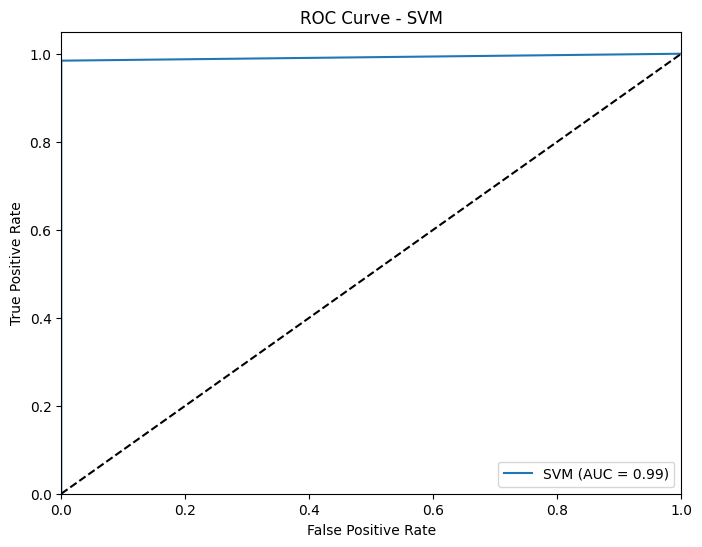

In [7]:
# Show training

stack = joblib.load('../../Models/70-30 Test/pipeline_lr.joblib')

# Use TFIDF inside of stacking to vectorize X_val(Evaluation)
vectorized_text = stack.named_steps['vectorizer'].transform(X_train)

metrics_df = pd.DataFrame(index=base_names + ['Stacking Model'], columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])

for model, name in zip(stack.named_steps['stacking'].estimators_ , base_names):
    y_pred = model.predict(vectorized_text)
    y_prob = model.predict_proba(vectorized_text)[:, 1]  # Probability for positive class for ROC curve

    accuracy = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)
    auc = roc_auc_score(y_train, y_prob)

    print(f"Metrics for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUC: {auc}")
    print(f"Classification Report:\n{classification_report(y_train, y_pred)}")

    metrics_df.loc[name] = [accuracy, precision, recall, f1, auc]

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_train, y_pred)
    roc_auc = roc_auc_score(y_train, y_pred)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.show()

Metrics for Stacking Model:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
AUC: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       942
           1       1.00      1.00      1.00       950

    accuracy                           1.00      1892
   macro avg       1.00      1.00      1.00      1892
weighted avg       1.00      1.00      1.00      1892



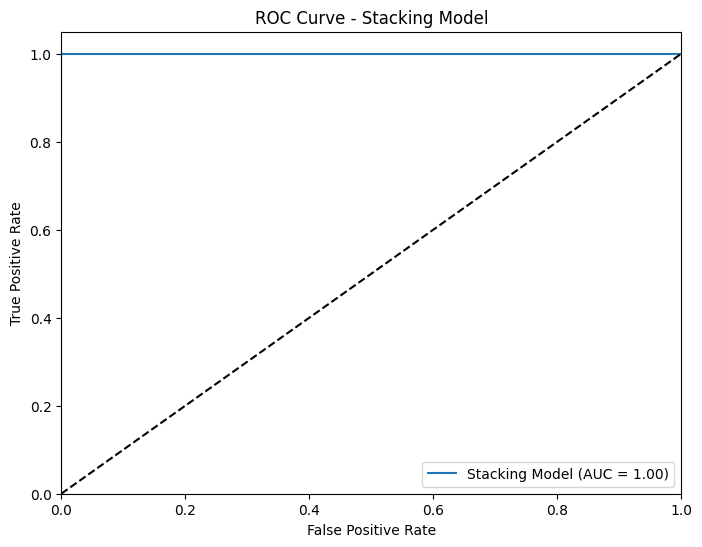

Comparison of Models:
                Accuracy Precision    Recall  F1 Score       AUC
MNB             0.938161  0.894787  0.993684  0.941646  0.995617
LR              0.943975  0.992991  0.894737  0.941307  0.996655
RF              0.989429       1.0  0.978947  0.989362  0.999904
KNN             0.901691  0.859023  0.962105  0.907646  0.977611
SVM             0.992072       1.0  0.984211  0.992042  0.999987
Stacking Model       1.0       1.0       1.0       1.0       1.0


In [8]:
# Evaluate stacking model
stack_y_pred = stack.predict(X_train)
stack_y_prob = stack.predict_proba(X_train)[:, 1]  # Probability for positive class for ROC curve

stack_accuracy = accuracy_score(y_train, stack_y_pred)
stack_precision = precision_score(y_train, stack_y_pred)
stack_recall = recall_score(y_train, stack_y_pred)
stack_f1 = f1_score(y_train, stack_y_pred)
stack_auc = roc_auc_score(y_train, stack_y_prob)

print("Metrics for Stacking Model:")
print(f"Accuracy: {stack_accuracy}")
print(f"Precision: {stack_precision}")
print(f"Recall: {stack_recall}")
print(f"F1 Score: {stack_f1}")
print(f"AUC: {stack_auc}")
print(f"Classification Report:\n{classification_report(y_train, stack_y_pred)}")

# ROC Curve for stacking model
stack_fpr, stack_tpr, _ = roc_curve(y_train, stack_y_prob)
stack_roc_auc = roc_auc_score(y_train, stack_y_prob)

# Store stacking model metrics in the DataFrame
metrics_df.loc['Stacking Model'] = [stack_accuracy, stack_precision, stack_recall, stack_f1, stack_auc]


# Plot ROC Curve for stacking model
plt.figure(figsize=(8, 6))
plt.plot(stack_fpr, stack_tpr, label=f'Stacking Model (AUC = {stack_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Stacking Model')
plt.legend(loc="lower right")
plt.show()

# Display the comparison table
print("Comparison of Models:")
print(metrics_df)